In [11]:
import pandas as pd
import numpy as np

# --- GENERATOR DATA MENTAH (JANGAN DIUBAH) ---
np.random.seed(101)
n_cust = 2000

data = {
    'Tenure_Bulan': np.random.randint(1, 72, n_cust),           
    'Tagihan_Bulanan': np.random.randint(150000, 1500000, n_cust), 
    'Total_Bayar': np.zeros(n_cust) 
}
df_churn = pd.DataFrame(data)

# 1. Hitung Total Bayar (+ Noise)
df_churn['Total_Bayar'] = df_churn['Tenure_Bulan'] * df_churn['Tagihan_Bulanan'] + np.random.randint(-50000, 50000, n_cust)

# 2. Bikin Target CHURN (Logika Bisnis)
score = (df_churn['Tagihan_Bulanan'] / 1500000 * 70) - (df_churn['Tenure_Bulan'] / 72 * 50) + np.random.randint(-10, 10, n_cust)
threshold = np.percentile(score, 70) 
df_churn['Churn'] = np.where(score > threshold, 1, 0)

# --- INJEKSI "KOTORAN" DATA (SUPAYA KAMU ADA KERJAAN CLEANSING) ---
# A. Bikin Data Bolong (Missing Values)
# Ada 20 pelanggan yang Total_Bayar-nya kosong (NaN)
df_churn.loc[10:30, 'Total_Bayar'] = np.nan 

# B. Bikin Data Duplikat
# Kita copy 10 baris pertama dan masukkan lagi ke bawah
df_churn = pd.concat([df_churn, df_churn.iloc[:10]], ignore_index=True)

# C. Bikin Outlier (Data Ngaco)
# Ada 1 orang yang tagihannya MINUS (Error sistem)
df_churn.loc[50, 'Tagihan_Bulanan'] = -500000 

print("📁 Data Mentah Siap Diolah!")
print(f"Total Baris Awal: {df_churn.shape[0]}")
print(df_churn.head())

📁 Data Mentah Siap Diolah!
Total Baris Awal: 2010
   Tenure_Bulan  Tagihan_Bulanan  Total_Bayar  Churn
0            12           315725    3742057.0      0
1            71           835475   59365415.0      0
2            64          1429808   91471779.0      0
3            10          1460529   14655075.0      1
4            41          1344684   55152831.0      0


In [12]:
df_churn

,Tenure_Bulan,Tagihan_Bulanan,Total_Bayar,Churn
0,12,315725,3742057.0,0
1,71,835475,59365415.0,0
2,64,1429808,91471779.0,0
3,10,1460529,14655075.0,1
4,41,1344684,55152831.0,0
...,...,...,...,...
2005,5,1404195,7055704.0,1
2006,64,684668,43863963.0,0
2007,41,341511,13999486.0,0
2008,61,522157,31863672.0,0


In [23]:
df_churn = df_churn.fillna(df_churn['Tagihan_Bulanan'].median())


In [27]:
df_churn['Churn'].value_counts()

Churn
0    1408
1     602
Name: count, dtype: int64

In [61]:
numeric = df_churn.select_dtypes('number').columns
numeric

Index(['Tenure_Bulan', 'Tagihan_Bulanan', 'Total_Bayar', 'Churn'], dtype='object')

In [59]:
df_churn = df_churn.drop_duplicates()


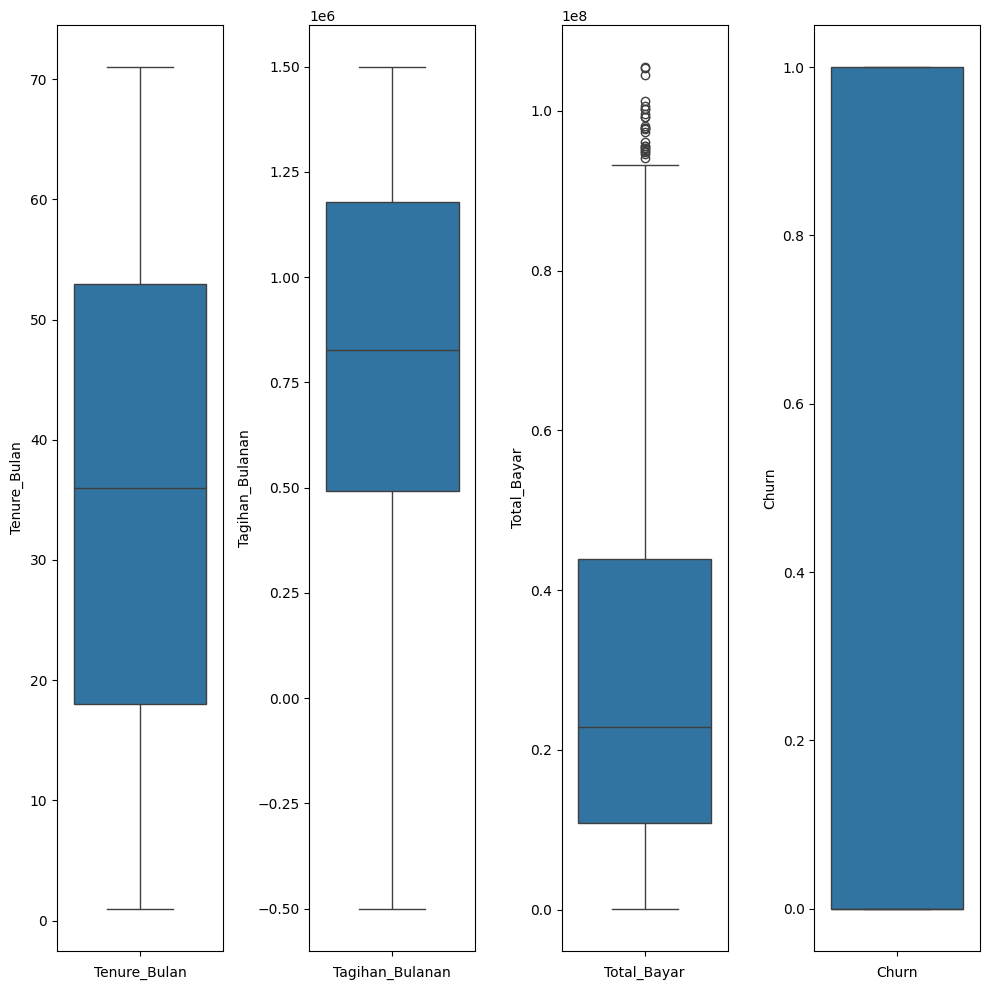

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
for i, column in enumerate(numeric):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(df_churn[column])
    plt.xlabel(column)
plt.tight_layout()

In [94]:
q1 = df_churn[numeric].quantile(0.25)
q3 = df_churn[numeric].quantile(0.75)

iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

condition = ~((df_churn[numeric] < lower) | (df_churn[numeric] > upper )).any(axis=1)
df_filtered_numeric = df_churn.loc[condition, numeric]
df_filtered_numeric


,Tenure_Bulan,Tagihan_Bulanan,Total_Bayar,Churn
0,12,315725,3742057.0,0
1,71,835475,59365415.0,0
2,64,1429808,91471779.0,0
3,10,1460529,14655075.0,1
4,41,1344684,55152831.0,0
...,...,...,...,...
1995,9,819097,7388151.0,1
1996,36,339679,12265734.0,0
1997,53,213165,11330683.0,0
1998,68,796335,54171161.0,0


In [116]:
df = df_filtered_numeric[df_filtered_numeric['Tagihan_Bulanan'] >= 0]

/tmp/ipykernel_14935/960541184.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[column], palette = 'viridis')
/tmp/ipykernel_14935/960541184.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[column], palette = 'viridis')
/tmp/ipykernel_14935/960541184.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[column], palette = 'viridis')
/tmp/ipykernel_14935/960541184.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[column], palette = 'viridis')


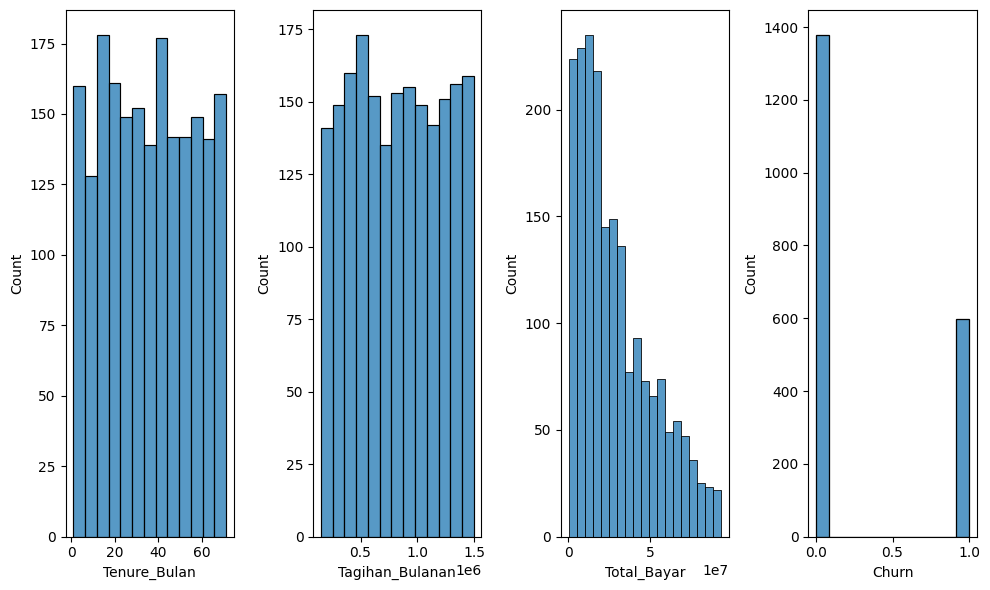

In [117]:
plt.figure(figsize=(10, 6))
for i, column in enumerate(numeric):
    plt.subplot(1, 4, i + 1)
    sns.histplot(df[column], palette = 'viridis')
plt.tight_layout()
plt.show()

In [124]:
from sklearn.model_selection import train_test_split

x = df.drop(columns='Churn')
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42)



In [125]:
X_train

,Tenure_Bulan,Tagihan_Bulanan,Total_Bayar
202,48,1122554,53895334.0
1005,53,573408,30421080.0
1666,65,564586,36656760.0
339,29,1022202,29613789.0
1358,30,1005376,30170071.0
...,...,...,...
1145,38,773999,29369355.0
1312,71,1072471,76137662.0
872,9,588966,5279766.0
1479,71,702020,49889677.0


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_churn = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)


array([[ 0.59793105,  0.74522351,  1.10221726],
       [ 0.84436549, -0.65736711,  0.0640336 ],
       [ 1.43580814, -0.67989965,  0.33981579],
       ...,
       [-1.32425756, -0.61762995, -1.04787825],
       [ 1.73152947, -0.32887526,  0.92506114],
       [-1.07782313, -1.63629387, -1.16213688]])

In [151]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

model = {
    'knn' : KNeighborsClassifier(),
    'rf' : RandomForestClassifier(),
    'svm' : SVC(random_state = 42)
}

for nama, model in model.items():
    model.fit(scaler_churn, y_train)

    y_pred = model.predict(test_scaled)
    skor = accuracy_score(y_test, y_pred)
    print(f"{nama.ljust(15)} : {skor:.4f} ({skor*100:.2f}%)")


knn             : 0.9139 (91.39%)
rf              : 0.9291 (92.91%)
svm             : 0.9241 (92.41%)
